# Спектрально-корреляционный анализ временных рядов

In [1]:
import os
import numpy as np
import random as random_number
%pylab
%matplotlib inline
%run ./load_notebook.py

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


### Графическое представление исходного ряда во временной области

In [2]:
# Заданные параметры ряда

deltaT = 1. # шаг выборки
N = 230  # число точек ряда
q = 0.01  # уровень значимости
X1 = 9. # критическое значение разделения шумового от детерменированного компонент
A1 = 1.  # амплитуда
nu1 = 0.1  # частота
phi1 = 0   # фаза
gamma =  0.5 # отношение сигнал к шуму
alpha = 0.1 # параметры линейного тренда
beta = 0.05

In [3]:
sigma_n = np.sqrt(A1**2 / 2*gamma) #среднеквадратическое отклонение шумового компонента

In [4]:
def model_series(t):
    n_k = random_number.normalvariate(0,1) # находим значение случайной величины нормального распределения
    return alpha + beta * t + A1*np.cos(2*np.pi*nu1*t - phi1) + sigma_n * n_k

In [5]:
X = []
t = []
for k in range(N):
    t.append(deltaT*k)
    X.append(model_series(deltaT*k))

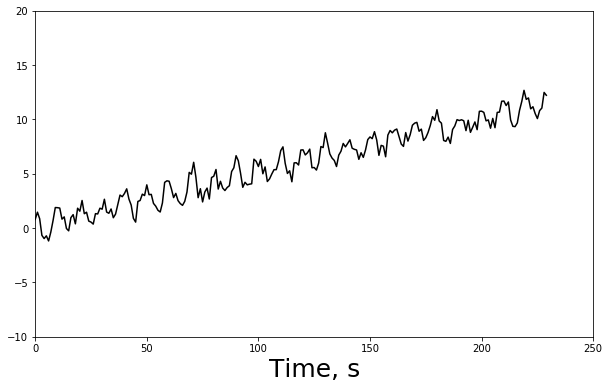

In [6]:
fig = plt.figure(figsize=[10,6])
plt.plot(t,X,'-',color = 'black')
plt.ylim(-10,20)
plt.xlim(0,250)
plt.xlabel('Time, s', fontsize = 25)
plt.show()

### Исключение тренда и центрирование ряда

In [7]:
# Найдём параметры модельного тренда с помощью МНК
A = np.vstack([t, np.ones(len(t))]).T 
a, b = np.linalg.lstsq(A, X)[0]

/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
# Вычитаем значения тренда из исходных данных
for i,tk in enumerate(t):
    X[i] = X[i] - a*tk - b

In [9]:
#Определим среднее значение ряда
X_cente=[]
m = np.sum(X)/N
X_centre = X - m

### Графическое представление центрированного ряда

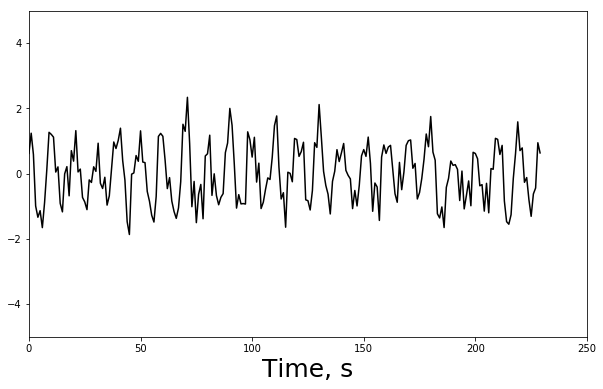

In [10]:
fig = plt.figure(figsize=[10,6])
plt.plot(t,X_centre,'-',color = 'black')
plt.ylim(-5,5)
plt.xlim(0,250)
plt.xlabel('Time, s', fontsize = 25)
plt.show()

### Вычисление периодорграммы

In [11]:
N1 = 512
N2 = 1024
#Дополним массив нулями
X_centre1 = []
for i in range(N2):
    if (i <= N-1):
        X_centre1.append(X_centre[i]) 
    else:
        X_centre1.append(0.)        

In [12]:
# Проведём процедуру БПФ
X_FFT = []
X_FFT = np.fft.fft(X_centre1) 

In [13]:
# Вычислим периодограмму
D = []
for i in range(N1):
    D.append(((X_FFT[i].real)**2 + (X_FFT[i].imag)**2)/N**2)

In [14]:
# Найдём частоты соответствующие периодограмме
delta_nu = 1 / (N2 * deltaT)
nu = [ i * delta_nu for i in range(N1)]

### Оценивание дисперсии ряда

In [15]:
sigma0_square = np.sum((X_centre)**2)/(N-1)

### Графическое представление периодограммы и порога обнаружения сигнала

In [16]:
#Критический уровень, позволяющий отождествить значимые спектральные пики
crit_level = sigma0_square * X1 / N

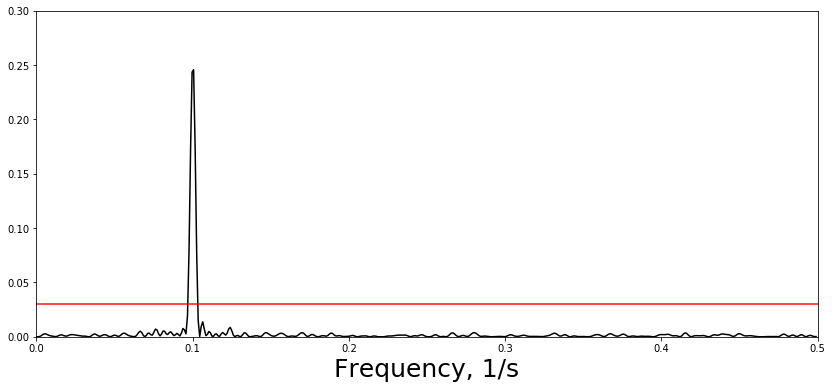

In [17]:
fig = plt.figure(figsize=[14,6])
plt.plot(nu,D,'-',color = 'black')
plt.ylim(0,0.3)
plt.xlim(0,0.5)
plt.xlabel('Frequency, 1/s', fontsize = 25)
plt.axhline(y=crit_level, alpha=0.7, color='red', lw=2)
plt.show()

### Вычисление коррелограммы

In [19]:
X_IFFT = []
# Найдём квадрат нормы массива, состоящего из комплексных чисел
X_FFT_abs = [(X_FFT[i].real)**2 + (X_FFT[i].imag)**2 for i in range(N2)]
# Найдём обратное преобразование Фурье от предыдущего массива
X_IFFT = np.fft.ifft(X_FFT_abs)

In [20]:
#Коррелограмма
C = [X_IFFT[i].real / N for i in range(N)]

### Графическое представление коррелограммы

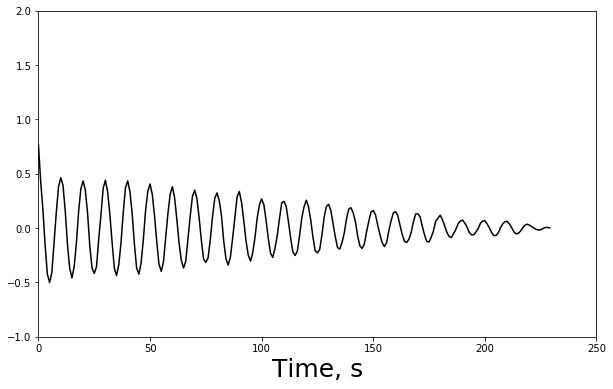

In [21]:
fig = plt.figure(figsize=[10,6])
plt.plot(t,C,'-',color = 'black')
plt.ylim(-1,2)
plt.xlim(0,250)
plt.xlabel('Time, s', fontsize = 25)
plt.show()

### Взвешенная коррелограмма

In [22]:
# Получим весовую функцию Тьюки
a_param = [0.25, 0.25] 
N_param = [int(N * 0.1), int(N * 0.5)]
W1 = [(1 - 2*a_param[0]) + 2*a_param[0]*np.cos(np.pi*m/N_param[0]) for m in range(N_param[0])]
W2 = [(1 - 2*a_param[1]) + 2*a_param[1]*np.cos(np.pi*m/N_param[1]) for m in range(N_param[1])]

In [23]:
# Вычислим взвешенную коррелограмму и дополним массив нулями
C_weighted1 = []
for i in range(N2):
    if (i <= N_param[0]-1):
        C_weighted1.append(C[i] * W1[i]) 
    else:
        C_weighted1.append(0.)
        
C_weighted2 = []
for i in range(N2):
    if (i <= N_param[1]-1):
        C_weighted2.append(C[i] * W2[i]) 
    else:
        C_weighted2.append(0.)        

### Вычисление сглаженной периодограммы

In [24]:
C_weighted_FFT1 = np.fft.fft(C_weighted1)
D_smooth1 = [(2 * C_weighted_FFT1[i].real - C_weighted1[0]) / N_param[0] for i in range(N1)]

C_weighted_FFT2 = np.fft.fft(C_weighted2)
D_smooth2 = [(2 * C_weighted_FFT2[i].real - C_weighted2[0]) / N_param[1] for i in range(N1)]

### Представление сглаженной периодограммы

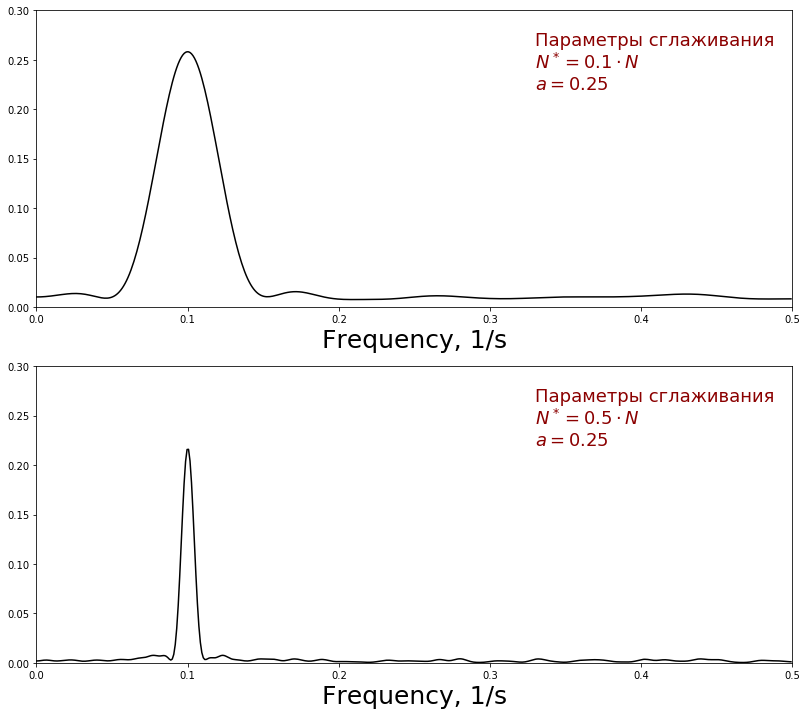

In [49]:
fig = plt.figure(figsize=[14,12])

plt.subplot(2,1,1)
textstr = '\n'.join((
    'Параметры сглаживания',
    r'$N^* = 0.1 \cdot N$',
    r'$a = 0.25$' ))
plt.text(0.33, 0.22, textstr, fontsize=18,wrap=True, color='darkred')
plt.plot(nu,D_smooth1,'-',color = 'black')
plt.ylim(0,0.3)
plt.xlim(0,0.5)
plt.xlabel('Frequency, 1/s', fontsize = 25)
plt.subplots_adjust(left=0.15)

plt.subplot(2,1,2)
textstr = '\n'.join((
    'Параметры сглаживания',
    r'$N^* = 0.5 \cdot N$',
    r'$a = 0.25$' ))
plt.text(0.33, 0.22, textstr, fontsize=18,wrap=True,color='darkred')
plt.plot(nu,D_smooth2,'-',color = 'black')
plt.ylim(0,0.3)
plt.xlim(0,0.5)
plt.xlabel('Frequency, 1/s', fontsize = 25)

plt.subplots_adjust(left=0.15)
plt.show()